`TODO`:
1. Fix case where number of column or row is 1
2. Fix case where ground truth of matrix R and D is not correct

In [21]:
# %%writefile merge/heuristics.py
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np
import torch
from tqdm import tqdm

In [22]:
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel
from merge.heuristics import *

SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train'
CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/chunk_label.json'
MODEL_WEIGHT = '/Users/longhoang/Developer/table-reg/pretrain-models/split-merge/split_v2.pth'

In [23]:
# Helper functions
def view_imgs(imgs, titles=None):
    fig = plt.figure(figsize=(7, 7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        if titles is not None:
            plt.title(titles[i])
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

In [24]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = SplitModel(3)
net = torch.nn.DataParallel(net).to(device)

if device == 'cuda':
    net.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    net.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [25]:
# LOAD DATA AND GROUND TRUTH
scitsr_subset = os.path.join(SCITSR_PATH, 'train')
# scitsr_val = os.path.join(SCITSR_PATH, 'val')
img_dir = os.path.join(scitsr_subset, 'img')

imgs_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
print(f'Loaded {len(imgs_paths)} images')

with open(CHUNK_JSON_LABEL, 'r') as f:
    chunk_labels = json.load(f)
print(f'Loaded {len(chunk_labels)} chunk labels (text bounding boxes)')

merge_label_path = os.path.join(scitsr_subset, 'label', 'merge_label.json')
with open(merge_label_path, 'r') as f:
    merge_labels = json.load(f)
print(f'Loaded {len(merge_labels)} merge labels')

split_label_path = os.path.join(scitsr_subset, 'label', 'split_label.json')
with open(split_label_path, 'r') as f:
    split_labels = json.load(f)
dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
print(f'Loaded dataset with {len(dataset)} examples')

Loaded 10000 images
Loaded 11971 chunk labels (text bounding boxes)
Loaded 10000 merge labels
Loaded dataset with 10000 examples


In [26]:
# %%writefile -a merge/heuristics.py

def torch2numpy(img:torch.tensor, r:torch.tensor, c:torch.tensor):
    '''
    Args:
        img -- torch tensor of shape (C, H, W)
        r -- torch tensor of shape (1, H)
        c -- torch tensor of shape (1, W)
    '''
    img = (img * 255).numpy().transpose(1,2,0).astype(np.uint8)
    r = r[-1]>0.5
    c = c[-1]>0.5
    c = c.cpu().detach().numpy().astype(np.uint8)
    r = r.cpu().detach().numpy().astype(np.uint8)
    return img, r, c

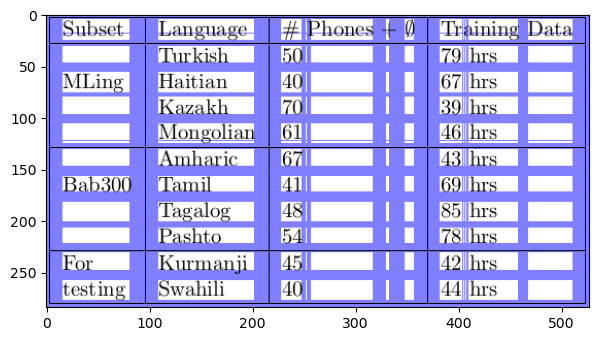

In [27]:
# VISUALIZE SPLIT PREDICTION
def vis_split(img, r, c, color='blue'):
    if color == 'red': theme = (255,0,0)
    elif color == 'green': theme = (0,255,0)
    else: theme = (0,0,255)
    r_im = r.reshape((-1,1)) * np.ones((r.shape[0],c.shape[0]))
    c_im = c.reshape((1,-1)) * np.ones((r.shape[0],c.shape[0]))
    bg = np.maximum(r_im, c_im)
    bg_img = np.concatenate(
        [bg[...,np.newaxis] * color for color in theme],
        axis=2
    )
    bg_img[np.all(bg_img == (0, 0, 0), axis=-1)] = (255,255,255)
    split_img = ((0.5 * img) + (0.5 * bg_img)).astype("uint8")
    split_img = np.minimum(split_img, img)
    view_imgs([split_img])

IDX = 0
img, label, img_name = dataset[IDX]
net.eval()
r_pred,c_pred = net(img.unsqueeze(0))
img, r_pred, c_pred = torch2numpy(img, r_pred, c_pred)
vis_split(img, r_pred, c_pred)

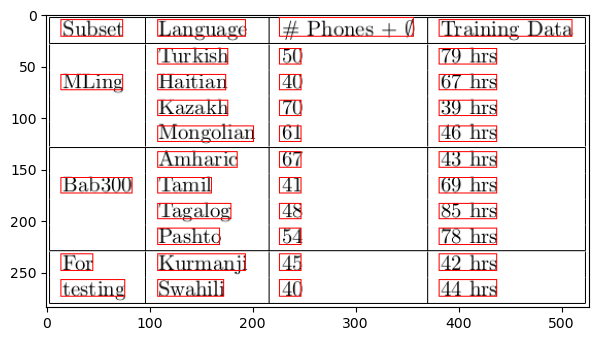

In [28]:
texts_pos = chunk_labels[img_name]

img2 = img.copy()
for text, (l, t, r_, b) in texts_pos:
    cv.rectangle(img2, (l, t), (r_, b), (255, 0, 0), 1)
view_imgs([img2])

In [29]:
# %%writefile merge/heuristics.py

def refine(x, threshold=2, adj_threshold=5):
    updated_x = x.copy()

    # Find indices of 1's in the array
    ones_indices = np.where(updated_x == 1)[0]

    # Iterate through the 1's indices and check for merging conditions
    i = 0
    while i < len(ones_indices):
        start_idx = ones_indices[i]
        end_idx = start_idx + threshold - 1

        # Check if there is another group of 1's within adj_threshold to the left or right
        if i + threshold < len(ones_indices) and ones_indices[i + threshold] - end_idx <= adj_threshold:
            end_idx = ones_indices[i + threshold]

            # Update all 1's in the range between the two groups to 1
            updated_x[start_idx:end_idx + 1] = 1

            # Move to the next unprocessed index
            i += threshold
        else:
            # Check if the merging condition is satisfied at the beginning of the array
            if start_idx - threshold >= 0 and start_idx - ones_indices[i - threshold] <= adj_threshold:
                start_idx = ones_indices[i - threshold]

                # Update all 1's in the range between the two groups to 1
                updated_x[start_idx:end_idx + 1] = 1
            else:
                updated_x[start_idx:end_idx + 1] = 0

            i += 1

    return updated_x

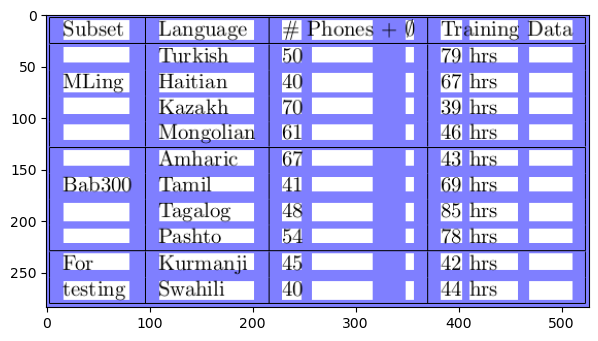

In [30]:
r_pred = refine(r_pred)
c_pred = refine(c_pred)
vis_split(img, r_pred, c_pred)

In [31]:
def load_GT(merge_labels, img_name):
    r_gt = np.array(merge_labels[img_name]['rows'])
    c_gt = np.array(merge_labels[img_name]['columns'])
    R_gt = np.array(merge_labels[img_name]['h_matrix'])
    D_gt = np.array(merge_labels[img_name]['v_matrix'])
    return r_gt, c_gt, R_gt, D_gt

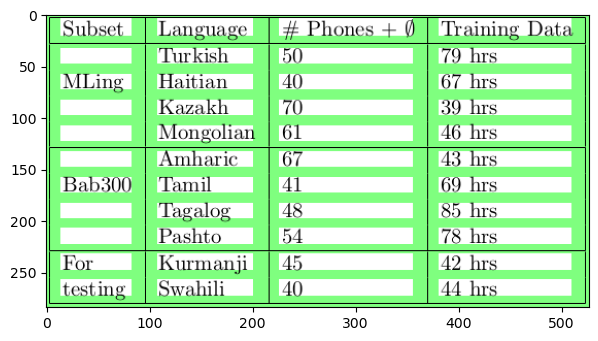

In [32]:
r_gt, c_gt, R_gt, D_gt = load_GT(merge_labels, img_name)
vis_split(img, r_gt, c_gt, 'green')

In [33]:
def border_pos(x):
    '''
    Args:
    x -- binary numpy array of shape (N,)
    Returns:
    idxs -- numpy array containing the indexes of x where values change from 0 to 1 or vice versa
    '''
    x = x.astype(np.int8)
    changes = np.array([abs(x[i+1] - x[i]) for i in range(len(x)-1)])
    idxs = np.where(changes == 1)[0]
    # when first cell is right at the beginning
    if x[0] == 0:
        idxs = np.concatenate(([0], idxs))
    # when last cell is at the end
    if len(idxs) % 2 != 0: # NOTE: check this again
        idxs = np.concatenate((idxs, [len(x) - 1]))
    return idxs

In [34]:
row_idxs = border_pos(r_pred)
col_idxs = border_pos(c_pred)

In [35]:
class Cell:
    def __init__(self, top, left, bottom, right):
        self.top = top
        self.left = left
        self.bottom = bottom
        self.right = right
        self.pos = (top, left), (bottom, right)
    def __str__(self):
        return f"t={self.top}, l={self.left}, b={self.bottom}, r={self.right}"

def get_cells(row_idxs, col_idxs):
    '''
    Args:
    row_idxs -- indexes of rows' borders
    col_idxs -- indexes of cols' borders
    Returns:
    cells -- list of Cells
    '''
    cells = []
    for i in range(0, len(row_idxs), 2):
        for j in range(0, len(col_idxs), 2):
            if (i + 1) >= len(row_idxs) or (j + 1) >= len(col_idxs): 
                continue
            top, left = row_idxs[i], col_idxs[j]
            bottom, right = row_idxs[i+1], col_idxs[j+1]
            cells.append(Cell(top, left, bottom, right))
    return cells

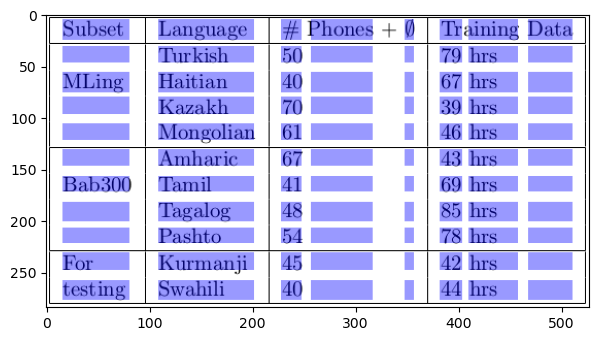

In [36]:
cells_pred = get_cells(row_idxs, col_idxs)
img2 = img.copy()
for i, cell in enumerate(cells_pred):
    cv.rectangle(img2, (cell.left, cell.top), (cell.right, cell.bottom), (0, 0, 255), -1)
res = cv.addWeighted(img2, 0.4, img, 0.6, 0)

view_imgs([res])

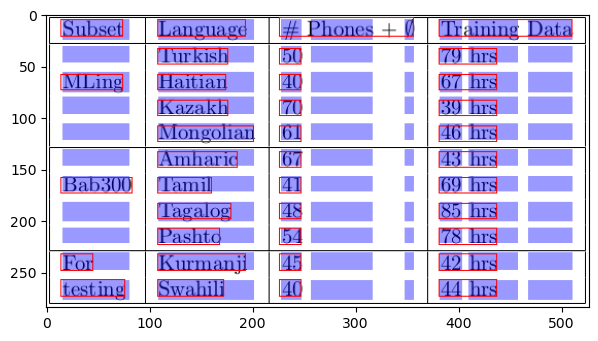

In [37]:
img2 = res.copy()

for text, (l, t, r_pred, b) in texts_pos:
    cv.rectangle(img2, (l, t), (r_pred, b), (255, 0, 0), 1)

view_imgs([img2])

In [38]:
def create_pred_matrices(row_idxs, col_idxs):
    num_rows, num_cols = round(len(row_idxs) / 2), round(len(col_idxs) / 2)
    if num_rows <= 0 or num_cols <= 0: return None
    R_pred = np.zeros((num_rows, num_cols-1), dtype=np.uint8) # merge RIGHT matrix
    D_pred = np.zeros((num_rows-1, num_cols), dtype=np.uint8) # merge DOWN matrix
    return R_pred, D_pred

In [39]:
R_pred, D_pred = create_pred_matrices(row_idxs, col_idxs)
R_pred.shape, D_pred.shape

((11, 7), (10, 8))

`Rule 1:` Merge cells where predicted seperator passes through text

In [40]:
def id2coord(id, n_cols):
    x = id // n_cols
    y = id % n_cols
    return x, y

def neighbor_RD(idx, num_rows, num_cols):
    idx_right = idx + 1 if (idx + 1) % num_cols != 0 else None
    idx_down = idx + num_cols if (idx + num_cols) < (num_rows * num_cols) else None
    return idx_right, idx_down

# NOTE: these two functions are not quite efficient yet
def check_merge_right(id, id_r, cells, texts_pos):
    (top, left), (bottom, right) = cells[id].pos
    (_, left_r), (_, right_r) = cells[id_r].pos
    for text, (l, t, r, b) in texts_pos:
        if l < right and left_r < r and \
            (top < t < bottom or top < b < bottom):
            return True
    return False

def check_merge_down(id, id_d, cells, texts_pos):
    (top, left), (bottom, right) = cells[id].pos
    (top_d, _), (bottom_d, _) = cells[id_d].pos
    for text, (l, t, r, b) in texts_pos:
        if t < bottom and top_d < b and \
            (left < l < right or left < r < right):
            return True
    return False

def rule1(cells, texts_pos, R_pred, D_pred, verbose=False):
    '''Inplace update prediction matrices R and D'''
    num_rows, num_cols = R_pred.shape[0], D_pred.shape[1]
    for id, cell in enumerate(cells):
        merge_r, merge_d = None, None
        x, y = id2coord(id, num_cols)
        rn, dn = neighbor_RD(id, num_rows, num_cols)
        if rn:
            merge_r = check_merge_right(id, rn, cells, texts_pos)
            if merge_r: 
                R_pred[x, y] = 1
                if verbose: print(f'Merge right at cell ({x},{y})')
        if dn:
            merge_d = check_merge_down(id, dn, cells, texts_pos)
            if merge_d: 
                D_pred[x, y] = 1
                if verbose: print(f'Merge down at cell ({x},{y})')

In [41]:
rule1(cells_pred, texts_pos, R_pred, D_pred, True)

Merge right at cell (0,2)
Merge right at cell (0,3)
Merge right at cell (0,5)
Merge right at cell (0,6)
Merge right at cell (1,5)
Merge right at cell (2,5)
Merge right at cell (3,5)
Merge right at cell (4,5)
Merge right at cell (5,5)
Merge right at cell (6,5)
Merge right at cell (7,5)
Merge right at cell (9,5)
Merge right at cell (10,5)


`Rule 2:` In the first row (likely header row), merge non-blank cells with adjacent blank cells

In [42]:
def is_blank(id, cells, texts_pos):
    (top, left), (bottom, right) = cells[id].pos
    for text, (l, t, r, b) in texts_pos:
        if (top < b and bottom > t) and (left < r and right > l):
            return False
    return True

def rule2(cells, texts_pos, R_pred, D_pred, verbose=False):
    # NOTE: currently only merge right for cells in the first
    #       row if its right neighbour is blank to avoid ambiguity
    num_rows, num_cols = R_pred.shape[0], D_pred.shape[1]
    for id, cell in enumerate(cells):
        x, y = id2coord(id, num_cols)
        rn, dn = neighbor_RD(id, num_rows, num_cols)

        if x == 0 and rn: # first row and has right neighbour
            # if right cell is blank and current cell is non-blank, merge right
            if not is_blank(id, cells, texts_pos) and is_blank(rn, cells, texts_pos):
                R_pred[x, y] = 1
                if verbose: print(f'Merge right at cell ({x},{y})')

In [43]:
rule2(cells_pred, texts_pos, R_pred, D_pred, verbose=True)

# Evaluation

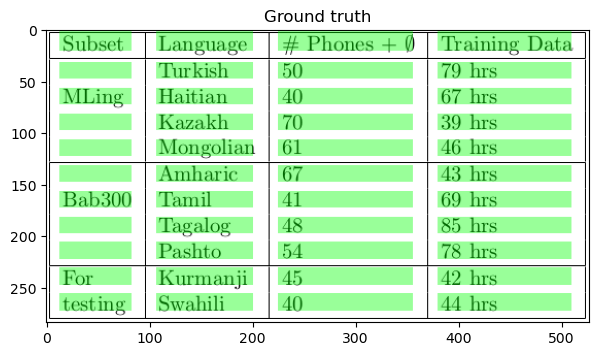

In [44]:
row_gt_idxs, col_gt_idxs = border_pos(r_gt), border_pos(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)

img2 = img.copy()
for i, cell in enumerate(cells_gt):
    cv.rectangle(img2, (cell.left, cell.top), (cell.right, cell.bottom), (0, 255, 0), -1)
res = cv.addWeighted(img2, 0.4, img, 0.6, 0)

view_imgs([res], ['Ground truth'])

In [45]:
img_name

'1802.07420v2.1'

In [46]:
# NOTE: might need to check L-shape case
def merge_right(cell, cell_right):
    (t1, l1), (b1, r1) = cell.pos
    (t2, l2), (b2, r2) = cell_right.pos
    assert t1 == t2 and b1 == b2, "Top and bottom of two cells don't match when merging right"
    assert l1 <= r2, "Cell to merge right is to the left of current cell"
    return Cell(t1, l1, b1, r2)

def merge_down(cell, cell_down):
    (t1, l1), (b1, r1) = cell.pos
    (t_down, l_down), (b_down, r_down) = cell_down.pos
    assert l1 == l_down and r1 == r_down, "Left and right boundaries of two cells don't match when merging down"
    assert b1 <= t_down, "Cell to merge down is not just below the current cell"
    return Cell(t1, l1, b_down, r1)

def merge_cells(cells, Rmatrix, Dmatrix, verbose=False):
    cells_mgr = []
    checked = []
    n_rows = Rmatrix.shape[0] if Rmatrix.ndim == 2 else 0
    n_cols = Dmatrix.shape[1] if Dmatrix.ndim == 2 else 0
    # assert len(cells) == n_rows * n_cols, "Shape of R and D don't match the number of cells"
    if len(cells) != n_rows * n_cols:
        n_cols = len(cells) // n_rows
    for id, cell in enumerate(cells):
        if id in checked: continue
        x, y = id2coord(id, n_cols)
        rn_id, dn_id = neighbor_RD(id, n_rows, n_cols)
        if rn_id is not None and Rmatrix[x, y] == 1:
            if verbose: print(f'Merge right at cell ({x},{y})')
            cells_mgr.append(merge_right(cell, cells[rn_id]))
            checked.append(rn_id)
        elif dn_id is not None and Dmatrix[x, y] == 1:
            if verbose: print(f'Merge down at cell ({x},{y})')
            cells_mgr.append(merge_down(cell, cells[dn_id]))
            checked.append(dn_id)
        else:
            cells_mgr.append(cell)
    return cells_mgr

Merge right at cell (0,2)
Merge right at cell (0,5)
Merge right at cell (1,5)
Merge right at cell (2,5)
Merge right at cell (3,5)
Merge right at cell (4,5)
Merge right at cell (5,5)
Merge right at cell (6,5)
Merge right at cell (7,5)
Merge right at cell (9,5)
Merge right at cell (10,5)


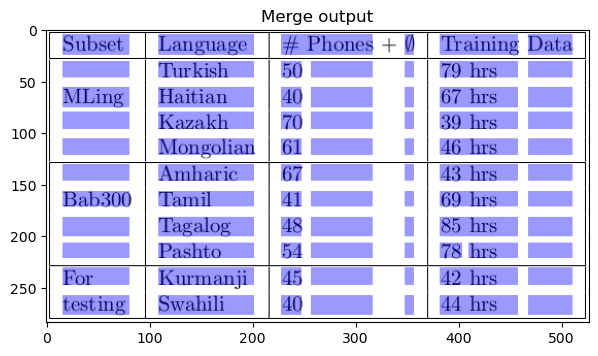

In [47]:
cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred, True)
img_mgr = img.copy()

for cell in cells_merged_pred:
    (t, l), (b, r_pred) = cell.pos
    cv.rectangle(img_mgr, (l, t), (r_pred, b), (0, 0, 255), -1)
res = cv.addWeighted(img_mgr, 0.4, img, 0.6, 0)

view_imgs([res], ['Merge output'])

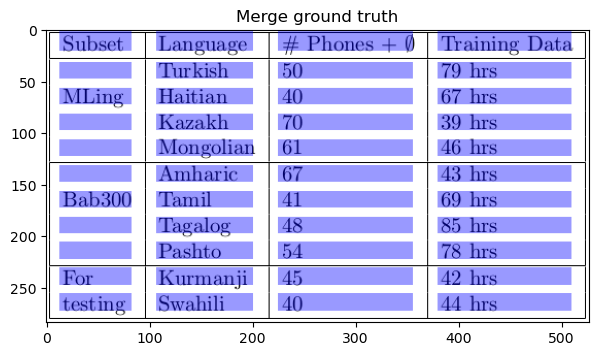

In [48]:
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, True)
img_mgr = img.copy()

for cell in cells_merged_gt:
    (t, l), (b, r_pred) = cell.pos
    cv.rectangle(img_mgr, (l, t), (r_pred, b), (0, 0, 255), -1)
res = cv.addWeighted(img_mgr, 0.4, img, 0.6, 0)

view_imgs([res], ['Merge ground truth'])

In [49]:
def IoU(cell_1, cell_2):
    (t1, l1), (b1, r1) = cell_1.pos
    (t2, l2), (b2, r2) = cell_2.pos

    # Check for invalid bounding boxes
    if t1 >= b1 or l1 >= r1 or t2 >= b2 or l2 >= r2:
        print('Coordinates of the cells are invalid')
        return 0.0

    inner_top, inner_left = max(t1, t2), max(l1, l2)
    inner_bot, inner_right = min(b1, b2), min(r1, r2)

    if inner_bot >= inner_top and inner_right >= inner_left:
        inner_area = (inner_bot - inner_top) * (inner_right - inner_left)
        area_1 = (b1 - t1) * (r1 - l1)
        area_2 = (b2 - t2) * (r2 - l2)

        # Use floating-point division
        union_area = area_1 + area_2 - inner_area
        return inner_area / union_area if union_area > 0 else 0.0
    else:
        return 0.0
    
def eval(cells_pred, cells_label, threshold=0.7):
    '''Returns F1, recall, and precision score'''
    n_correct_preds = 0
    n_preds, n_true = len(cells_pred), len(cells_label)

    # Count true positives, false positives, and false negatives
    for pred_box in cells_pred:
        max_iou = 0
        for true_box in cells_label:
            iou = IoU(pred_box, true_box)
            if iou > max_iou:
                max_iou = iou

        if max_iou >= threshold:
            n_correct_preds += 1

    # Calculate precision, recall, and F1 score
    precision = n_correct_preds / n_preds if n_preds > 0 else 0.0
    recall = n_correct_preds / n_true if n_true > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1, recall, precision

In [50]:
eval(cells_merged_pred, cells_merged_gt)

(0.2975206611570248, 0.4090909090909091, 0.23376623376623376)

## Get result on the whole set

In [224]:
def merge_heuristics(model: SplitModel, 
                     img_dir: str, 
                     split_json: str, 
                     merge_json: str, 
                     chunk_json: str):
    '''
    Args:
    model -- Split model
    img_dir -- string, path to image folder of train or test set
    split_json -- string, path to json ground truth file for Split module
    merge_json -- string, path to json ground truth file for Merge module
    chunk_json -- string, path to json file that contain chunk info (coordinates of texts)
    '''
    # Load images
    imgs_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
    print(f'Got {len(imgs_paths)} images')

    # Load Merge labels
    with open(merge_json, 'r') as f:
        merge_labels = json.load(f)
    print(f"Loaded {len(merge_labels)} labels for Merge module")

    # Load Text posisions
    with open(chunk_json, 'r') as f:
        chunk_labels = json.load(f)
    print(f"Loaded texts positions for {len(chunk_labels)} images")

    # Load dataset
    with open(split_json, 'r') as f:
        split_labels = json.load(f)
    dataset = ImageDataset(img_dir, split_labels, 8, scale=1, returns_image_name=True)
    print(f'Loaded dataset with {len(dataset)} examples')

    single_col_or_row = []
    shape_mismatch = []
    wrong_label = []
    f1s, recalls, precisions = [], [], []
    model.eval()
    for img, label, img_name in tqdm(dataset):
        texts_pos = chunk_labels[img_name]
        # load ground truth
        r_gt, c_gt, R_gt, D_gt = load_GT(merge_labels, img_name)
        if R_gt.ndim != 2 or D_gt.ndim != 2: 
            single_col_or_row.append(img_name)
            continue
        row_gt_idxs, col_gt_idxs = border_pos(r_gt), border_pos(c_gt)
        cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
        if len(cells_gt) != R_gt.shape[0] * D_gt.shape[1]:
            shape_mismatch.append(img_name)
            continue
        cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt)
        # get predictions
        with torch.no_grad():
            r_pred, c_pred = model(img.unsqueeze(0))
        img, r_pred, c_pred = torch2numpy(img, r_pred, c_pred)
        r_pred, c_pred = refine(r_pred), refine(c_pred)
        row_pred_idxs, col_pred_idxs = border_pos(r_pred), border_pos(c_pred)                                      
        cells_pred = get_cells(row_pred_idxs, col_pred_idxs)
        if len(row_pred_idxs) == 0 or len(col_pred_idxs) == 0:
            wrong_label.append(img_name)
            continue
        # apply Merge heuristics
        R_pred, D_pred = create_pred_matrices(row_pred_idxs, col_pred_idxs)
        rule1(cells_pred, texts_pos, R_pred, D_pred)
        rule2(cells_pred, texts_pos, R_pred, D_pred)
        cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred)
        # get evaluation scores
        f1, rec, prec = eval(cells_merged_pred, cells_merged_gt)
        f1s.append(f1); recalls.append(rec); precisions.append(prec)

    f1_avg, rec_avg, prec_avg = np.mean(f1s), np.mean(recalls), np.mean(precisions)
    print(f'F1: {f1_avg:.4f} ; Recall: {rec_avg:.4f} ; Precision: {prec_avg:.4f}')
    scores = {
        'f1': f1_avg, 'recall': rec_avg, 'precision': prec_avg
    }
    errors = {
        'single': single_col_or_row, 'shape_mismatch': shape_mismatch, 'wrong_label': wrong_label
    }
    return scores, errors

In [225]:
# Evaluate on train set
def evaluate_set(set_dir, chunk_json):
    img_dir = os.path.join(set_dir, 'img')
    split_json = os.path.join(set_dir, 'label/split_label.json')
    merge_json = os.path.join(set_dir, 'label/merge_label.json')
    return merge_heuristics(net, img_dir, split_json, merge_json, chunk_json)

In [226]:
TRAIN_DIR = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train/train'
scores, errors = evaluate_set(TRAIN_DIR, CHUNK_JSON_LABEL)

Got 10000 images
Loaded 10000 labels for Merge module
Loaded texts positions for 11971 images
Loaded dataset with 10000 examples


100%|██████████| 10000/10000 [54:57<00:00,  3.03it/s] 


F1: 0.6237 ; Recall: 0.6538 ; Precision: 0.6045


In [229]:
len(errors['single']), len(errors['shape_mistach']), len(errors['wrong_label'])

(8, 1057, 10)

In [231]:
def save_dict(dict, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    for key in errors.keys():
        p = os.path.join(dir_path, key + '.json')
        with open(p, 'w') as f:
            json.dump(dict[key], f)

In [233]:
ERROR_PATH = '/Users/longhoang/Developer/table-reg/code/deep-split-merge-scitsr/merge/error/train'

save_dict(errors, ERROR_PATH)

In [234]:
VAL_DIR = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train/val'
val_scores, val_errors = evaluate_set(VAL_DIR, CHUNK_JSON_LABEL)

Got 1971 images
Loaded 1971 labels for Merge module
Loaded texts positions for 11971 images
Loaded dataset with 1971 examples


100%|██████████| 1971/1971 [11:04<00:00,  2.97it/s]


F1: 0.6412 ; Recall: 0.6719 ; Precision: 0.6215


In [236]:
VAL_ERROR_PATH = '/Users/longhoang/Developer/table-reg/code/deep-split-merge-scitsr/merge/error/val'

save_dict(val_errors, VAL_ERROR_PATH)

In [238]:
len(val_errors['single']), len(val_errors['shape_mistach']), len(val_errors['wrong_label'])

(1, 229, 2)

In [239]:
val_errors['shape_mistach']

['1601.04798v3.1',
 '1607.03057v1.1',
 '1011.2269v1.2',
 '1503.08294v1.2',
 '1003.0487v1.1',
 '1711.00322v1.2',
 '1611.01587v5.4',
 '1803.11088v1.6',
 '1709.06175v1.1',
 '1712.02768v1.3',
 '1803.02446v1.4',
 '1703.03098v2.1',
 '0705.4676v8.1',
 '1011.2269v1.1',
 '1604.05633v2.16',
 '1804.00433v2.5',
 '1205.6787v1.1',
 '1301.0722v2.5',
 '1509.05366v1.1',
 '1601.04469v1.5',
 '1310.4713v1.5',
 '1711.05861v1.3',
 '1301.6793v1.1',
 '1507.08539v1.3',
 '0711.3149v1.6',
 '1708.04755v1.3',
 '1709.06257v1.6',
 '1605.05142v1.2',
 '1211.4896v1.4',
 '1611.01346v2.2',
 '1408.1209v1.5',
 '1004.4024v1.7',
 '1712.03257v1.1',
 '1601.06081v1.5',
 '1705.10861v1.1',
 '1711.10177v1.5',
 '1608.00139v2.2',
 '1205.4973v3.5',
 '1610.01209v1.1',
 '1703.03193v1.1',
 '1605.07686v2.3',
 '1201.5604v2.1',
 '0312006v1.3',
 '1103.1432v2.4',
 '1307.1424v3.1',
 '1505.06872v1.5',
 '1805.08403v3.2',
 '1804.10750v1.2',
 '1804.02630v1.1',
 '0303010v1.1',
 '1609.01743v1.6',
 '1608.00293v1.13',
 '1805.04074v1.2',
 '1803.01499v